In [25]:
'''
This notebook calculates the distance from the 3' end to spliced junctions from LRS data.
Figures 3 and S4
'''

'\nThis notebook calculates the distance to splicing and plots panels for Figure 3 and Figure S4\n'

In [1]:
import os
import re

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import mygene
import scipy

from plotnine import *
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # export pdfs with editable font types in Illustrator

In [2]:
# Links to input data: BED12 files that have been filtered to remove splicing intermediates
dataFiles = [
    '../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique_no_splicing_int.bed',
     ]

dataFiles_nanoCOP = [
    '../1_filter_data/nanoCOP_data/SRR8268942_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268943_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268944_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268945_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268946_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268947_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268948_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8268949_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932660_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932661_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932662_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932663_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932664_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932665_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932666_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932667_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR8932668_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR10097603_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR10097604_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR10097605_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR10097606_sorted_unique.bed',
    '../1_filter_data/nanoCOP_data/SRR10097607_sorted_unique.bed'
]

# Link to SraRunTable.txt experiment info file for nanoCOP data
srainfo = pd.read_csv('../0_mapped_data/nanoCOP/SraRunTable.txt', delimiter = ',', header = 0)

# link to files with introns filtered for CoSE calculation from Figure 2
gt_5reads_un = pd.read_csv('../Figure_2_S3/introns_5read_cutoff_uninduced.txt', sep = '\t')
gt_10reads_un = pd.read_csv('../Figure_2_S3/introns_10read_cutoff_uninduced.txt', sep = '\t')
gt_20reads_un = pd.read_csv('../Figure_2_S3/introns_20read_cutoff_uninduced.txt', sep = '\t')

gt_5reads_ind = pd.read_csv('../Figure_2_S3/introns_5read_cutoff_induced.txt', sep = '\t')
gt_10reads_ind = pd.read_csv('../Figure_2_S3/introns_10read_cutoff_induced.txt', sep = '\t')
gt_20reads_ind = pd.read_csv('../Figure_2_S3/introns_20read_cutoff_induced.txt', sep = '\t')

In [3]:
# # Now reformat long to wide to compare uninduced and induced coSE values
# inner join induced and uninduced introns with gt10 coverage to keep introns that only pass the cutoff in both conditions
cose_wide_5 = pd.merge(gt_5reads_un, gt_5reads_ind, left_on = 'i_name', right_on = 'i_name', how = 'inner', suffixes = ['_uninduced', '_induced'])
cose_wide_10 = pd.merge(gt_10reads_un, gt_10reads_ind, left_on = 'i_name', right_on = 'i_name', how = 'inner', suffixes = ['_uninduced', '_induced'])
cose_wide_20 = pd.merge(gt_20reads_un, gt_20reads_ind, left_on = 'i_name', right_on = 'i_name', how = 'inner', suffixes = ['_uninduced', '_induced'])

# calculate cose for the intron in each condition
cose_wide_5['cose_uninduced'] = cose_wide_5['spliced_exact_uninduced']/cose_wide_5['total_uninduced']
cose_wide_5['cose_induced'] = cose_wide_5['spliced_exact_induced']/cose_wide_5['total_induced']
cose_wide_10['cose_uninduced'] = cose_wide_10['spliced_exact_uninduced']/cose_wide_10['total_uninduced']
cose_wide_10['cose_induced'] = cose_wide_10['spliced_exact_induced']/cose_wide_10['total_induced']
cose_wide_20['cose_uninduced'] = cose_wide_20['spliced_exact_uninduced']/cose_wide_20['total_uninduced']
cose_wide_20['cose_induced'] = cose_wide_20['spliced_exact_induced']/cose_wide_20['total_induced']

### Figure 3C

Spearman correlation coeff = 0.5586030847036088
Spearman p-value = 0.0
n = 4170 introns


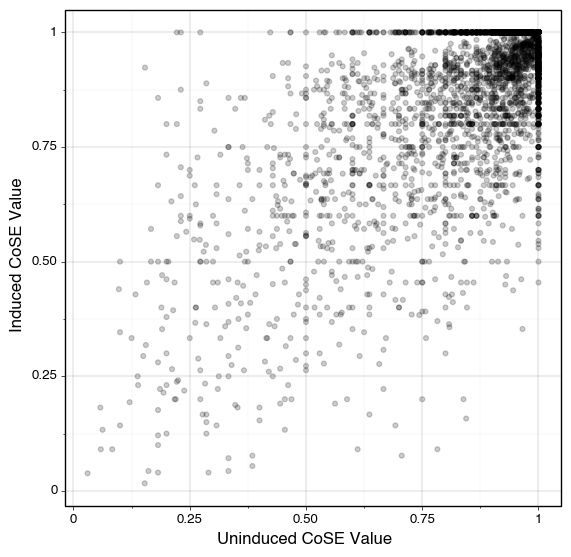

<ggplot: (8782732374361)>

In [5]:
# plot Uninduced vs. Induced CoSE

corr, p_value = scipy.stats.spearmanr(cose_wide_10['cose_uninduced'], cose_wide_10['cose_induced'])
print('Spearman correlation coeff = ' + str(corr))
print('Spearman p-value = ' + str(p_value))
print('n = ' + str(len(cose_wide_10)) + ' introns')

cose_induced_uninduced_10 = (ggplot
     (data=cose_wide_10, mapping=aes( x='cose_uninduced', y = 'cose_induced')) + 
      geom_point(alpha = 0.2) +
#       geom_bin2d(binwidth = .01, drop = True) + #to fill in all grey background
#       scale_fill_continuous(name = 'magma') +
#       scale_fill_cmap(name = 'magma') +
      theme_linedraw(base_size = 12, base_family = 'Helvetica') +
      theme(aspect_ratio = 1) +
      xlab('Uninduced CoSE Value') +
      ylab('Induced CoSE Value')
           )
cose_induced_uninduced_10

Spearman correlation coeff = 0.6300833412696943
Spearman p-value = 6.748532728587991e-142
n = 1274 introns


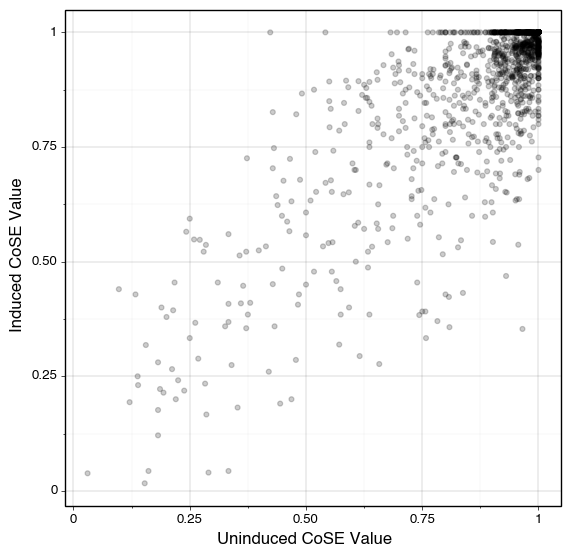

<ggplot: (8782735125981)>

In [6]:
corr, p_value = scipy.stats.spearmanr(cose_wide_20['cose_uninduced'], cose_wide_20['cose_induced'])
print('Spearman correlation coeff = ' + str(corr))
print('Spearman p-value = ' + str(p_value))
print('n = ' + str(len(cose_wide_20)) + ' introns')

cose_induced_uninduced_20 = (ggplot
     (data=cose_wide_20, mapping=aes( x='cose_uninduced', y = 'cose_induced')) + 
      geom_point(alpha = 0.2) +
#       geom_bin2d(binwidth = .01, drop = True) + #to fill in all grey background
#       scale_fill_continuous(name = 'magma') +
#       scale_fill_cmap(name = 'magma') +
      theme_linedraw(base_size = 12, base_family = 'Helvetica') +
      theme(aspect_ratio = 1) +
      xlab('Uninduced CoSE Value') +
      ylab('Induced CoSE Value')
           )
cose_induced_uninduced_20

Spearman correlation coeff = 0.44728714303805706
Spearman p-value = 0.0
n = 10851 introns


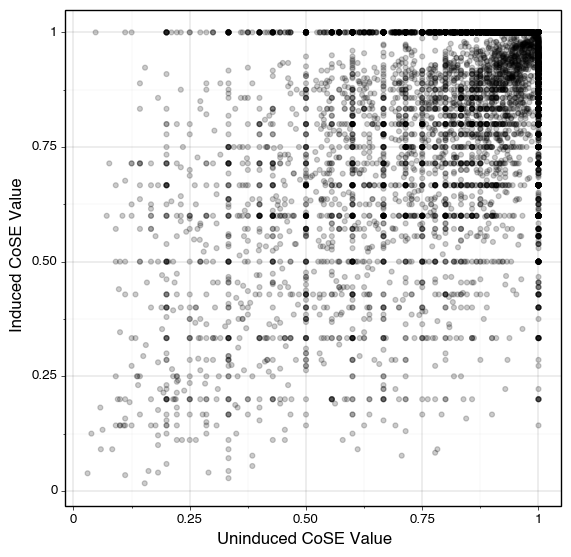

<ggplot: (8782735140517)>

In [7]:
corr, p_value = scipy.stats.spearmanr(cose_wide_5['cose_uninduced'], cose_wide_5['cose_induced'])
print('Spearman correlation coeff = ' + str(corr))
print('Spearman p-value = ' + str(p_value))
print('n = ' + str(len(cose_wide_5)) + ' introns')

cose_induced_uninduced_5 = (ggplot
     (data=cose_wide_5, mapping=aes( x='cose_uninduced', y = 'cose_induced')) + 
      geom_point(alpha = 0.2) +
#       geom_bin2d(binwidth = .01, drop = True) + #to fill in all grey background
#       scale_fill_continuous(name = 'magma') +
#       scale_fill_cmap(name = 'magma') +
      theme_linedraw(base_size = 12, base_family = 'Helvetica') +
      theme(aspect_ratio = 1) +
      xlab('Uninduced CoSE Value') +
      ylab('Induced CoSE Value')
           )
cose_induced_uninduced_5

In [36]:
# Define a function to get last block size, which is the distance from the last splice junction to the 3'end

def get_dist_to_splicing(file):
    f = open(file)

    output = [] # create an empty list for output to be added to
    
    filestring = file.split('/')[-1].split('_')[0:3]
    sample = '_'.join(filestring) # get sample ID from file name
    
    for line in f:
        line_split = line.split('\t')
        exon_size_list = line_split[10] # gets list of block (exon) sizes from BED12 file
        intron_size_list = line_split[11] # gets list of block starts
        strand = line_split[5]
        n_blocks = int(line_split[9])
        chr = line_split[0]
        exon_size = exon_size_list.split(",")
        intron_size = intron_size_list.split(",")
        
        if n_blocks > 1: # for spliced reads only...
            last_intron_size_plus = str(int(intron_size[-1]) - int(intron_size[-2]) - int(exon_size[-2]))
            last_intron_size_minus = str(int(intron_size[1]) - int(exon_size[0]))
           
            if strand == '+':
                read_end = line_split[2]
                upstream_intron_start_plus = (int(read_end) - int(exon_size[-1]) - int(last_intron_size_plus))
                upstream_intron_end_plus = (int(read_end) - int(exon_size[-1]))
                output.append([exon_size[-1], last_intron_size_plus, chr, str(upstream_intron_start_plus), str(upstream_intron_end_plus), str(strand), sample])

            if strand == '-':
                read_end = line_split[1]
                upstream_intron_end_minus = (int(read_end) + int(exon_size[0]))
                upstream_intron_start_minus = (int(read_end) + int(exon_size[0]) + int(last_intron_size_minus))
                output.append([exon_size[0], last_intron_size_minus, chr, str(upstream_intron_end_minus), str(upstream_intron_start_minus), str(strand), sample])
    
    df = pd.DataFrame(output, columns=['dist_to_splicing', 'upstream_intron_length', 'chr', 'start', 'end', 'strand', 'sample'])
    return df

In [37]:
# Define a function to get last block size for nanoCOP data, which is the distance from the last splice junction to the 3'end
# only difference for this from the pacbio data is getting the sample name from the filestring

def get_dist_to_splicing_nanoCOP(file):
    f = open(file)

    output = [] # create an empty list for output to be added to
    
    sample = file.split('/')[-1].split('_')[0] # get sample ID from file name
    
    for line in f:
        line_split = line.split('\t')
        exon_size_list = line_split[10] # gets list of block (exon) sizes from BED12 file
        intron_size_list = line_split[11] # gets list of block starts
        strand = line_split[5]
        n_blocks = int(line_split[9])
        chr = line_split[0]
        exon_size = exon_size_list.split(",")
        intron_size = intron_size_list.split(",")
        
        if n_blocks > 1: # for spliced reads only...
            last_intron_size_plus = str(int(intron_size[-1]) - int(intron_size[-2]) - int(exon_size[-2]))
            last_intron_size_minus = str(int(intron_size[1]) - int(exon_size[0]))
           
            if strand == '+':
                read_end = line_split[2]
                upstream_intron_start_plus = (int(read_end) - int(exon_size[-1]) - int(last_intron_size_plus))
                upstream_intron_end_plus = (int(read_end) - int(exon_size[-1]))
                output.append([exon_size[-1], last_intron_size_plus, chr, str(upstream_intron_start_plus), str(upstream_intron_end_plus), str(strand), sample])

            if strand == '-':
                read_end = line_split[1]
                upstream_intron_end_minus = (int(read_end) + int(exon_size[0]))
                upstream_intron_start_minus = (int(read_end) + int(exon_size[0]) + int(last_intron_size_minus))
                output.append([exon_size[0], last_intron_size_minus, chr, str(upstream_intron_end_minus), str(upstream_intron_start_minus), str(strand), sample])
    
    df = pd.DataFrame(output, columns=['dist_to_splicing', 'upstream_intron_length', 'chr', 'start', 'end', 'strand', 'sample'])
    return df

In [38]:
# Calculate distance to splicing for all PacBio samples and combine output in one dataframe
df_list = []
for file in dataFiles:
    df_list.append(get_dist_to_splicing(file))
    
df = pd.concat(df_list)

df['dist_to_splicing'] = df['dist_to_splicing'].astype('int')
df['upstream_intron_length'] = df['upstream_intron_length'].astype('int') # convert calculated distances to integers

# Calculate distance to splicing for all nanoCOP samples and combine output in one dataframe
df_list_nanoCOP = []
for file in dataFiles_nanoCOP:
    df_list_nanoCOP.append(get_dist_to_splicing_nanoCOP(file))
    
df_nanoCOP = pd.concat(df_list_nanoCOP)

df_nanoCOP['dist_to_splicing'] = df_nanoCOP['dist_to_splicing'].astype('int')
df_nanoCOP['upstream_intron_length'] = df_nanoCOP['upstream_intron_length'].astype('int') # convert calculated distances to integers

In [39]:
# Describe pacbio and nanoCOP distance to splicing dataframe basic statistics
print(df.describe())
print(df_nanoCOP.describe())

       dist_to_splicing  upstream_intron_length
count     168567.000000           168567.000000
mean         278.820161             4565.427361
std          373.265527            17026.447937
min            7.000000               30.000000
25%           75.000000              266.000000
50%          142.000000              875.000000
75%          306.000000             2451.000000
max         6010.000000           376961.000000
       dist_to_splicing  upstream_intron_length
count     292182.000000           292182.000000
mean         509.544264             6055.951397
std          568.628022            23777.493205
min            6.000000               30.000000
25%          137.000000              107.000000
50%          311.000000              554.000000
75%          686.000000             2143.000000
max         9731.000000           509391.000000


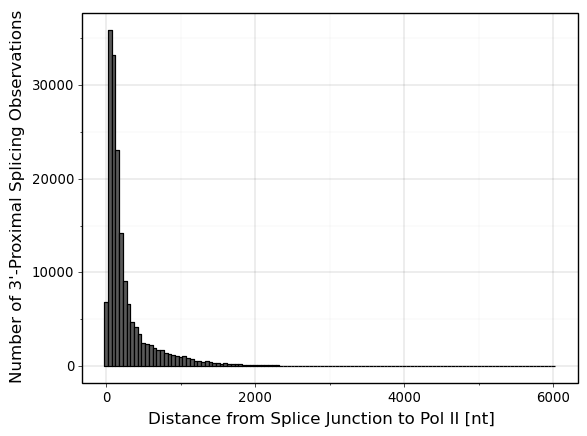

<ggplot: (8780742604093)>

In [40]:
# Plot Pacbio distribution of distances to splicing
dist_to_splicing_hist = (ggplot
     (data = df, mapping = aes(x = 'dist_to_splicing')) + 
      geom_histogram(binwidth = 50, position = 'stack', alpha = 1, colour = 'black') +
      theme_linedraw(base_size = 12) +
      xlab('Distance from Splice Junction to Pol II [nt]') +
      ylab("Number of 3'-Proximal Splicing Observations")
    )

dist_to_splicing_hist #NOTE: data is not normally distributed

In [41]:
# For nanoCOP samples, match accession ID to cell type using SraRunTable.txt experiment info file
df_nanoCOP_merged = pd.merge(df_nanoCOP, srainfo[['Run','source_name', 'cell_treatment']], left_on = 'sample', right_on = 'Run', how = 'left')
df_nanoCOP_merged = df_nanoCOP_merged.drop(columns = ['Run'])

# for MEL samples, add MEL as 'source_name'
df['source_name'] = 'MEL cells'

# For MEL samples, group uninduced and induced samples together, create 'cell_treatment' column
df['sample'] = df['sample'].astype('string')
df['cell_treatment'] = pd.np.where(df['sample'].str.contains("untreated"), "Uninduced", "Induced") # group by uninduced or DMSO string in sample name
cat_type = CategoricalDtype(categories=['Uninduced', 'Induced'], ordered=True) # turn group column into a category variable in order to control order of plotting

df['cell_treatment'] = df['cell_treatment'].astype(cat_type)

# combined pacbio and nanoCOP df's so they can be plotted together
df_all = pd.concat([df, df_nanoCOP_merged])

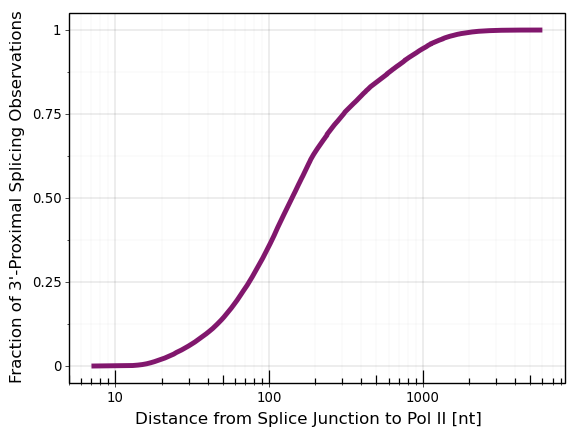

<ggplot: (8780743797637)>

In [42]:
# Plot cumulative frequency plot of distances to splicing for all combined pacbio data
plot_ecdf = (ggplot
     (data = df, mapping = aes(x = 'dist_to_splicing')) + 
      theme_linedraw(base_size = 12) +
      stat_ecdf(geom = 'smooth', size = 2, color = '#81176D') +
      xlab('Distance from Splice Junction to Pol II [nt]') +
      ylab("Fraction of 3'-Proximal Splicing Observations") +
      scale_x_log10() +
      annotation_logticks(sides = "b") 
    )

plot_ecdf

In [43]:
# number of observations for induced and uninduced samples
print('uninduced: ' + str(len(df.loc[df['cell_treatment'] == 'Uninduced'])))
print('induced: ' + str(len(df.loc[df['cell_treatment'] == 'Induced'])))

uninduced: 101911
induced: 66656


In [45]:
# describe summary stats for induced and uninduced conditions
df.loc[df['cell_treatment'] == 'Uninduced']['dist_to_splicing'].describe()
df.loc[df['cell_treatment'] == 'Induced']['dist_to_splicing'].describe()

count    66656.000000
mean       258.333668
std        371.519051
min          7.000000
25%         70.000000
50%        128.000000
75%        250.000000
max       6010.000000
Name: dist_to_splicing, dtype: float64

### Figure 3B

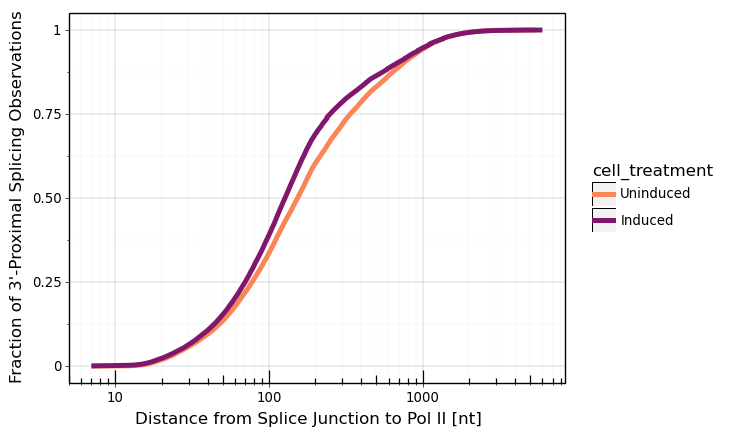

<ggplot: (8780742609805)>

In [47]:
# Plot the same as above, but separated by uninduced/induced treatment
plot_ecdf_treatment = (ggplot
     (data = df, mapping = aes(x = 'dist_to_splicing', colour = 'cell_treatment')) + 
      theme_linedraw(base_size = 12) +
      stat_ecdf(geom = 'smooth', size = 2) +
      xlab('Distance from Splice Junction to Pol II [nt]') +
      ylab("Fraction of 3'-Proximal Splicing Observations") +
      scale_colour_manual(values = ['#FA8657', '#81176D']) +
      scale_x_log10() +
      annotation_logticks(sides = "b") 
    )

plot_ecdf_treatment

### Figure S4A

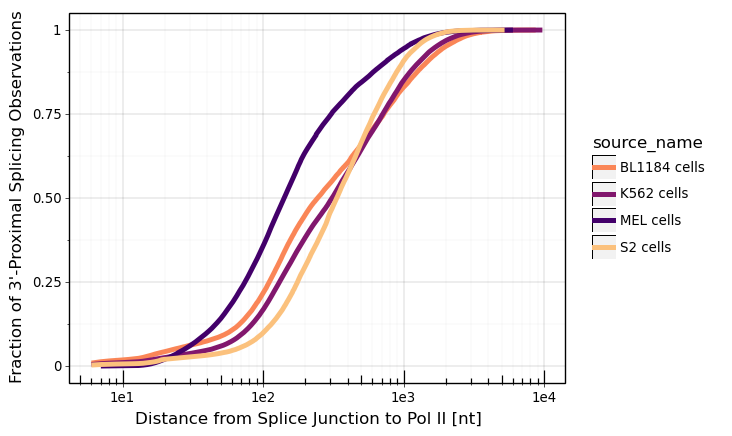

<ggplot: (8780742865869)>

In [48]:
# Plot distances to splicing for Drexler et al. nanoCOP data alongside MEL data
plot_ecdf_nanoCOP = (ggplot
     (data = df_all, mapping = aes(x = 'dist_to_splicing', colour = 'source_name')) + 
      theme_linedraw(base_size = 12) +
      stat_ecdf(geom = 'smooth', size = 2) +
      xlab('Distance from Splice Junction to Pol II [nt]') +
      ylab("Fraction of 3'-Proximal Splicing Observations") +
      scale_colour_manual(values = ['#FA8657', '#81176D', '#43006A', '#FBC17D']) +
      scale_x_log10() +
      annotation_logticks(sides = "b") 
    )

plot_ecdf_nanoCOP

In [49]:
# Group distance to splicing by cell type and summarize
df_all.groupby('source_name')['dist_to_splicing'].describe()

,count,mean,std,min,25%,50%,75%,max
source_name,,,,,,,,
BL1184 cells,39397.0,543.100414,700.068735,6.0,111.0,244.0,723.0,8719.0
K562 cells,183829.0,522.658830,591.260241,6.0,131.0,310.0,711.0,9731.0
MEL cells,168567.0,278.820161,373.265527,7.0,75.0,142.0,306.0,6010.0
S2 cells,68956.0,455.410479,392.502796,6.0,176.0,335.0,617.0,5237.0


### Figure S4B

p-value short vs. med = 0.3821168862869348
p-value med vs. long = 3.8571327125552825e-62


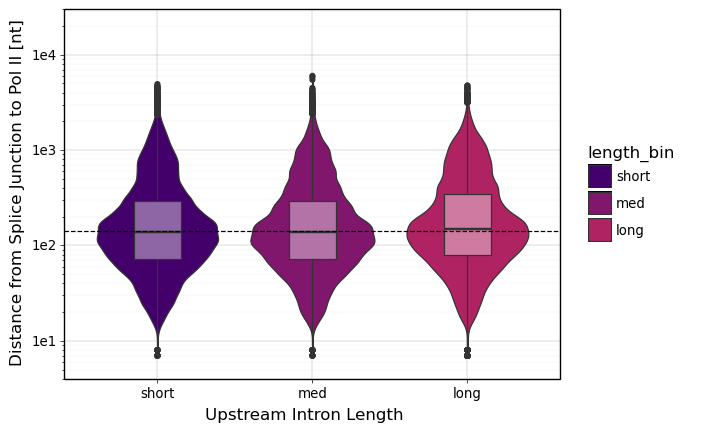

<ggplot: (8780743236745)>

In [50]:
# Plot distance to splicing vs. upstream intron length
# cut upstream intron length into bins to make violin plots
df['length_bin'] = pd.qcut(df['upstream_intron_length'], 3, labels = ['short', 'med', 'long'])

median = df['dist_to_splicing'].median()
my_colours = ['#43006A', '#81176D', '#B02363']

plot_up_intron_length = (ggplot
      (data = df, mapping = aes(x = 'length_bin', y = 'dist_to_splicing', fill = 'length_bin')) +
      geom_violin(width = 0.8) +
      geom_boxplot(width = 0.3, fill = 'white', alpha = 0.4) +
      geom_abline(intercept = np.log10(median), slope = 0, colour = 'black', linetype = 'dashed') +
      theme_linedraw(base_size = 12) +
      ylab('Distance from Splice Junction to Pol II [nt]') +
      xlab('Upstream Intron Length') +
      scale_y_log10() +
      scale_y_log10(limits = (6,20000)) +
      scale_fill_manual(values = my_colours)
    )

# make df of different length bins for statistical test
short = df[df['length_bin'] == 'short']
med = df[df['length_bin'] == 'med']
long = df[df['length_bin'] == 'long']

# calculate p-values between protein-coding and two non-coding category with MWU test
p_short_med = scipy.stats.mannwhitneyu(short['dist_to_splicing'], med['dist_to_splicing'])[1]
p_med_long = scipy.stats.mannwhitneyu(med['dist_to_splicing'], long['dist_to_splicing'])[1]

print('p-value short vs. med = ' + str(p_short_med))
print('p-value med vs. long = ' + str(p_med_long))
plot_up_intron_length

In [51]:
# print median distances to group...note that med vs. long is statistically significant but medians are quite similar
print('short intron median distance = ' + str(short['dist_to_splicing'].median()))
print('medium intron median distance = ' + str(med['dist_to_splicing'].median()))
print('long intron median distance = ' + str(long['dist_to_splicing'].median()))

short intron median distance = 138.0
medium intron median distance = 137.0
long intron median distance = 150.0


### Save output figures

In [9]:
plot_ecdf_treatment.save('cumulative_dist_to_splicing_induced_uninduced.pdf') # Fig 3B
plot_ecdf_nanoCOP.save('cumulative_dist_to_splicing_pacbio_nanocop.pdf') # Fig S4A
plot_up_intron_length.save('distance_to_splicing_vs_upstream_intron.pdf') # Fig S4B
cose_induced_uninduced_5.save('cose_uninduced_vs_induced_5.pdf') # for rebuttal
cose_induced_uninduced_10.save('cose_uninduced_vs_induced_10.pdf') # Fig 3C
cose_induced_uninduced_20.save('cose_uninduced_vs_induced_20.pdf') # for rebuttal